# Import

In [16]:
import os, joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Concatenate, Input

from sklearn.ensemble import RandomForestClassifier

In [17]:
current = os.getcwd()
os.chdir('../modelEval')

In [18]:
from scripts.evalModel import precision, getPredDist, countDrugsK

In [19]:
os.chdir(current)

# Load Data 

## RNA

In [5]:
trainRNA = pd.read_csv('../../data/processed/RNA_train_cancergenes.csv', index_col=0)
valRNA = pd.read_csv('../../data/processed/RNA_val_cancergenes.csv', index_col=0)
testRNA = pd.read_csv('../../data/processed/RNA_test_cancergenes.csv', index_col=0)
newRNA = pd.read_csv('../../data/processed/RNA_newcancer_cancergenes.csv', index_col=0)

## Drugs

In [6]:
drugs = pd.read_csv('../../data/processed/drug_fingerprints.csv', index_col=0)

## CDR

In [7]:
cdr = pd.read_csv('../../data/processed/drugCellLinePairsData.csv')
cdrFilt = cdr.loc[:, ['DepMap_ID', 'cancer_type', 'name', 'ic50', 'auc', 'effectiveCont', 'effective']]
cdrFilt.rename(columns={'DepMap_ID': 'cell_line', 'name': 'drug', 'effective': 'true'}, inplace=True)
cdrFilt.head()

,cell_line,cancer_type,drug,ic50,auc,effectiveCont,true
0,ACH-000320,Pancreatic Cancer,floxuridine,0.007879,0.336463,6.692422,0
1,ACH-001145,Ovarian Cancer,floxuridine,0.041552,0.485618,5.053845,0
2,ACH-000873,Esophageal Cancer,floxuridine,0.097745,0.548483,4.697597,0
3,ACH-000855,Esophageal Cancer,floxuridine,0.037349,0.631609,4.052632,0
4,ACH-000488,Esophageal Cancer,floxuridine,0.071628,0.598061,3.801377,0


# Process data

## Combine RNA

In [8]:
allRNA = pd.concat([trainRNA, valRNA])
allRNA.shape

(300, 463)

# Make result dfs

In [9]:
rows = ['fold0', 'fold1', 'fold2', 'fold3', 'fold4']
cols = ['p1', 'p2', 'p3', 'p4', 'p5', 'p10', 'nWrong', 'nUnique', 'variance']

In [10]:
clTest = pd.DataFrame(index=rows, columns=cols)
clNew = pd.DataFrame(index=rows, columns=cols)

ctTest = pd.DataFrame(index=rows, columns=cols[:5])
ctNew = pd.DataFrame(index=rows, columns=cols[:5])

# Define

## funcs

In [11]:
def loadEncoder(path, which='rna'):
    try:
        snn = load_model(path)
        encoder = snn.get_layer('model')
        encoder._name = f'{which}Encoder'
        return encoder
    except AttributeError:
        return None
    
def getModel(rnaPath=None, drugPath=None, rnaDim=463, drugDim=256):
        # Define encoded drug input
        drugInput = Input(drugDim)
        rnaInput = Input(rnaDim)
                                             
        if drugPath == None:
            if rnaPath == None:         
                pairEmbed = Concatenate()([drugInput, rnaInput])
            else: 
                rnaEmbed = loadEncoder(rnaPath)(rnaInput)
                pairEmbed = Concatenate()([drugInput, rnaEmbed])
        else:
            drugEmbed = loadEncoder(drugPath, which='drug')(drugInput)
            if rnaPath == None:         
                pairEmbed = Concatenate()([drugEmbed, rnaInput])
            else: 
                rnaEmbed = loadEncoder(rnaPath)(rnaInput)
                pairEmbed = Concatenate()([drugEmbed, rnaEmbed])

        return Model(inputs=[drugInput, rnaInput], outputs=pairEmbed)

## paths

In [12]:
# drugPath = '../../models/drugEncoders/'
drugPath = '/fs/scratch/PCON0041/PatrickLawrence/cancer-drug-response/fewShot/drugs/siameseV1/models/'
drugModel = 'DrugFewShot_Layers1_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
drugPath = os.path.join(drugPath, drugModel)

In [13]:
# rnaPath = '../../models/cellEncoders/'
# rnaModel = 'CellLineFewShot_Layers2_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
rnaPath = '/fs/scratch/PCON0041/PatrickLawrence/cancer-drug-response/fewShot/cellLines/siameseV1/models/'
rnaModel = 'CellLineFewShot_Layers2_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
rnaPath = os.path.join(rnaPath, rnaModel)

## Encoder model

In [20]:
encoder = getModel(rnaPath, drugPath)

/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: siamese is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [21]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 463)]        0           []                               
                                                                                                  
 drugEncoder (Functional)       (None, 64)           20608       ['input_1[0][0]']                
                                                                                                  
 rnaEncoder (Functional)        (None, 64)           38016       ['input_2[0][0]']                
                                                                                              

# 5-fold CV

## def model params

In [22]:
rfParams = {'criterion': 'gini', 
            'min_samples_split': 20, 
            'n_estimators': 100}

## encoder newcancer data

In [23]:
testCDR = cdrFilt[cdrFilt.cell_line.isin(testRNA.index)]

testData = encoder([drugs.loc[list(testCDR.drug.values), :].to_numpy(), 
                    testRNA.loc[list(testCDR.cell_line.values), :].to_numpy()]).numpy()

newCDR = cdrFilt[cdrFilt.cell_line.isin(newRNA.index)]

newData = encoder([drugs.loc[list(newCDR.drug.values), :].to_numpy(), 
                   newRNA.loc[list(newCDR.cell_line.values), :].to_numpy()]).numpy()

## Load folds

In [24]:
foldDF = pd.read_csv('../../data/processed/cellLinesForCV.csv')
foldDF.head()

,fold0,fold1,fold2,fold3,fold4
0,ACH-000741,ACH-000026,ACH-000720,ACH-000566,ACH-000890
1,ACH-000396,ACH-000753,ACH-000018,ACH-000011,ACH-000845
2,ACH-000839,ACH-000973,ACH-000905,ACH-000142,ACH-000875
3,ACH-000273,ACH-000231,ACH-000558,ACH-000756,ACH-000869
4,ACH-000323,ACH-000137,ACH-000469,ACH-000232,ACH-000572


## run

In [194]:
#666
np.random.seed(1738)
models = {}
for f in foldDF.columns:
    print(f)
    # get cell lines to use in test fold
    trainCellLines = list(foldDF.drop(f, axis=1).to_numpy().reshape(-1))
    
    # split data into test and train sets
    trainCDR = cdrFilt[cdrFilt.cell_line.isin(trainCellLines)].copy()
    
    # get raw RNA + Drug data
    trainData = encoder([drugs.loc[list(trainCDR.drug), :].to_numpy(), 
                         allRNA.loc[list(trainCDR.cell_line), :].to_numpy()]).numpy()
    
    # Get GT labels for train Data
    trainEff = trainCDR.true.to_numpy()
    
    
    model = RandomForestClassifier(**rfParams)
    model.fit(trainData, trainEff)
    
    # Test results (cell line)
    testPreds = testCDR.copy()
    testPreds['pred'] = [p[1] for p in model.predict_proba(testData)]
    testPreds.sort_values(by='pred', ascending=False, inplace=True)
    testCount, testWrong = countDrugsK(testPreds)
    clTest.loc[f, :] = precision(testPreds, thresh=0.1, at=1, by='cellLine', getResults=True) +\
                        [len(testWrong), len(testCount), round(testPreds.groupby('drug').pred.var().mean(),4)]
    
    # Test results (cancer)
    ctTest.loc[f, :] = list(precision(testPreds.copy(), thresh=0.1, by='cancer').mean())
    
    # New cancer results
    newPreds = newCDR.copy()
    newPreds['pred'] = [p[1] for p in model.predict_proba(newData)]
    newPreds.sort_values(by='pred', ascending=False, inplace=True)
    newCount, newWrong = countDrugsK(newPreds)
    newPrecision = precision(newPreds, thresh=0.1, at=1, by='cellLine', getResults=True)
    clNew.loc[f, :] =  newPrecision +\
                        [len(newWrong), len(newCount), round(newPreds.groupby('drug').pred.var().mean(),4)]
    
    # New cancer results (cancer)
    ctNew.loc[f, :] = list(precision(newPreds.copy(), thresh=0.1, by='cancer').mean())
    
    # Keep model
    models[f] = model


# cell line test
clTest.loc['mean', :] = clTest.iloc[:5,:].mean()
clTest.loc['std', :] = clTest.iloc[:5,:].std()
clTest.iloc[:, :6] = clTest.iloc[:, :6].astype(float).round(4)

# cancer test
ctTest.loc['mean', :] = ctTest.iloc[:5,:].mean()
ctTest.loc['std', :] = ctTest.iloc[:5,:].std()
ctTest = ctTest.astype(float).round(4)

# cell line new
clNew.loc['mean', :] = clNew.iloc[:5,:].mean()
clNew.loc['std', :] = clNew.iloc[:5,:].std()
clNew.iloc[:, :6] = clNew.iloc[:, :6].astype(float).round(4)

# cancer new
ctNew.loc['mean', :] = ctNew.iloc[:5,:].mean()
ctNew.loc['std', :] = ctNew.iloc[:5,:].std()
ctNew = ctNew.astype(float).round(4)

fold0
No true effective drugs identified in top 3 for ACH-000164 (top drug: epothilone-d)
	Precision@1: 0.9608
	Precision@2: 0.9216
	Precision@3: 0.8954
	Precision@4: 0.8824
	Precision@5: 0.8627
	Precision@10: 0.8103

No true effective drugs identified in top 3 for ACH-000250 (top drug: dolastatin-10)
No true effective drugs identified in top 3 for ACH-000268 (top drug: sangivamycin)
	Precision@1: 0.9692
	Precision@2: 0.9154
	Precision@3: 0.8872
	Precision@4: 0.8462
	Precision@5: 0.8369
	Precision@10: 0.8118

fold1
	Precision@1: 0.9608
	Precision@2: 0.951
	Precision@3: 0.9085
	Precision@4: 0.8725
	Precision@5: 0.8431
	Precision@10: 0.8179

No true effective drugs identified in top 3 for ACH-000250 (top drug: dolastatin-10)
No true effective drugs identified in top 3 for ACH-000268 (top drug: sangivamycin)
	Precision@1: 0.9385
	Precision@2: 0.9154
	Precision@3: 0.8974
	Precision@4: 0.8538
	Precision@5: 0.84
	Precision@10: 0.8137

fold2
	Precision@1: 0.9804
	Precision@2: 0.9118
	Precisio

# Results

## Test set 

In [195]:
clTest

,p1,p2,p3,p4,p5,p10,nWrong,nUnique,variance
fold0,0.9608,0.9216,0.8954,0.8824,0.8627,0.8103,1,19,0.0013
fold1,0.9608,0.951,0.9085,0.8725,0.8431,0.8179,0,17,0.0013
fold2,0.9804,0.9118,0.902,0.8725,0.851,0.8179,0,20,0.0013
fold3,0.9608,0.9216,0.8693,0.8529,0.8431,0.8256,1,18,0.0012
fold4,0.9608,0.8922,0.8824,0.848,0.8431,0.8205,1,17,0.0012
mean,0.9647,0.9196,0.8915,0.8657,0.8486,0.8185,0.6,18.2,0.00126
std,0.0088,0.0213,0.0157,0.0145,0.0086,0.0056,0.547723,1.30384,0.000055


In [196]:
ctTest

,p1,p2,p3,p4,p5
fold0,0.9728,0.9369,0.9027,0.8929,0.8632
fold1,0.9728,0.9589,0.9155,0.8744,0.8454
fold2,0.9792,0.9230,0.9049,0.8808,0.8509
fold3,0.9728,0.9318,0.8740,0.8557,0.8396
fold4,0.9583,0.9059,0.8868,0.8435,0.8433
mean,0.9712,0.9313,0.8968,0.8695,0.8485
std,0.0077,0.0194,0.0163,0.0198,0.0092


## New cancer set 

In [197]:
clNew

,p1,p2,p3,p4,p5,p10,nWrong,nUnique,variance
fold0,0.9692,0.9154,0.8872,0.8462,0.8369,0.8118,2,20,0.0014
fold1,0.9385,0.9154,0.8974,0.8538,0.84,0.8137,2,18,0.0013
fold2,0.9538,0.9,0.8667,0.8385,0.8431,0.8176,2,22,0.0014
fold3,0.9538,0.9154,0.8974,0.8615,0.8431,0.8,1,18,0.0013
fold4,0.9692,0.9154,0.8974,0.8769,0.8185,0.802,1,18,0.0012
mean,0.9569,0.9123,0.8892,0.8554,0.8363,0.809,1.6,19.2,0.00132
std,0.0129,0.0069,0.0134,0.0148,0.0103,0.0077,0.547723,1.788854,0.000084


In [198]:
ctNew

,p1,p2,p3,p4,p5
fold0,0.9852,0.9395,0.8755,0.8497,0.8340
fold1,0.9603,0.9321,0.9164,0.8510,0.8324
fold2,0.9518,0.9145,0.8595,0.8449,0.8565
fold3,0.9518,0.9369,0.8876,0.8662,0.8326
fold4,0.9590,0.9325,0.8811,0.8807,0.8279
mean,0.9616,0.9311,0.8840,0.8585,0.8367
std,0.0137,0.0098,0.0209,0.0147,0.0113


# Save CV results

In [199]:
clTest.to_csv('../../data/results/embedDrugEmbedCellConcatRF-cellLineTest.csv', index=False)
ctTest.to_csv('../../data/results/embedDrugEmbedCellConcatRF-cancerTest.csv', index=False)
clNew.to_csv('../../data/results/embedDrugEmbedCellConcatRF-cellLineNew.csv', index=False)
ctNew.to_csv('../../data/results/embedDrugEmbedCellConcatRF-cancerNew.csv', index=False)

# Save RF models

In [200]:
basePath = '../../models/fsCDR/RF/'
for fold, model in models.items():
    outpath = os.path.join(basePath, f'EmbedDrug-EmbedCell-Concat-RF-CV{fold}.joblib')
    joblib.dump(model, outpath, compress=3)

These can then be reloaded to get predicitons with joblib.load(\<file\>)

# Examine important features for RF

In [25]:
forest = joblib.load('../../models/fsCDR/RF/EmbedDrug-EmbedCell-Concat-RF-CVfold1.joblib')

In [26]:
feature_names = [f"drugFT{i}" for i in range(64)]
feature_names.extend([f"cellFT{i}" for i in range(64)])
importances = forest.feature_importances_

In [27]:
forest_importances = pd.Series(importances, index=feature_names)

In [28]:
def minMaxNorm(series):
    return (series - series.min()) / (series.max() - series.min())


def vizImportance(series, drugColor='#377eb8', cellColor='#e41a1c', norm=True):
    # process series / importance data
    if norm:
        series = minMaxNorm(series)
    series = series[series > 0.0].sort_values(ascending=False)
    
    # define bar colors
    colors = []
    for idx in series.index:
        if idx.startswith('drug'):
            colors.append(drugColor)
        else:
            colors.append(cellColor)
    
    # plot feature importance
    plt.figure(figsize=(20, 10))
    bars = plt.bar(series.index, series.values, color=colors)
    
    # plot avg importance by feature type
    avgCellImportance = series[series.index.str.startswith('cell')].mean()
    avgCellLine = plt.axhline(avgCellImportance, color=cellColor,
                linestyle='dashed', linewidth=3, label='Avg relative cell line feature importance')
    
    avgDrugImportance = series[series.index.str.startswith('drug')].mean()
    avgDrugLine = plt.axhline(avgDrugImportance, color=drugColor, 
                linestyle='dashed', linewidth=3, label='Avg relative drug feature importance')

    
    # create legend
    drugLeg = mpatches.Patch(color=drugColor, label='Drug features')
    cellLeg = mpatches.Patch(color=cellColor, label='Cell line features')
    plt.legend(handles=[drugLeg, cellLeg, avgDrugLine, avgCellLine], loc=1, fontsize=20)
    
    # format plot
    plt.xlim([0-0.5,len(series)-0.5])
    plt.xticks([])
    plt.ylim([0.0,1.0])
    plt.yticks([0, 1], fontsize=20)
    plt.show()

<ipython-input-204-5c2e99bd4072>:40: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


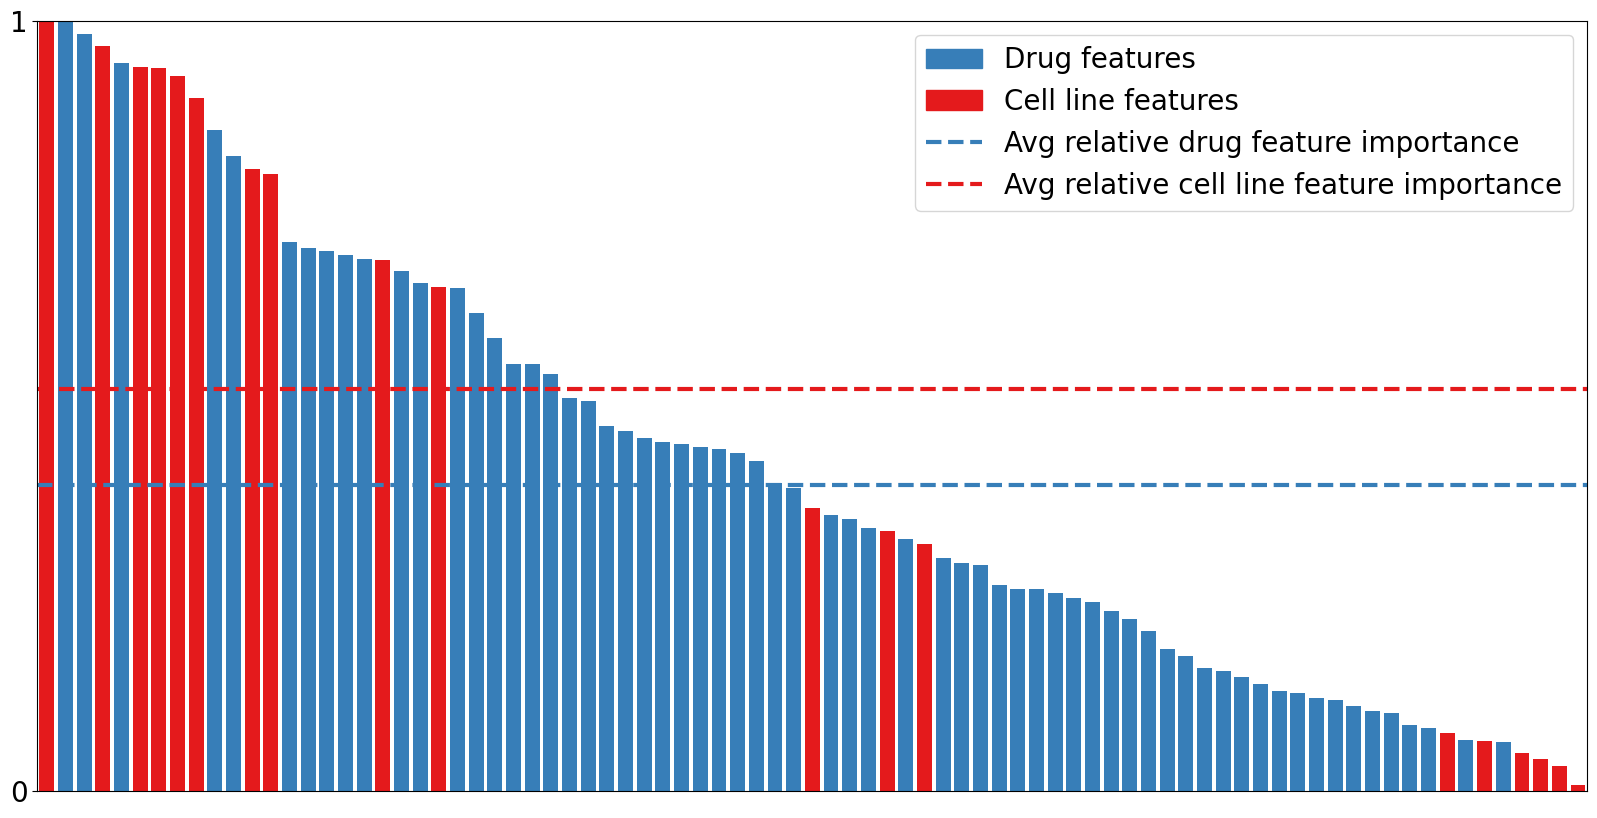

In [205]:
vizImportance(forest_importances)

# Examine results from best fold

In [30]:
testCDR['pred'] = [p[1] for p in forest.predict_proba(testData)]
testPreds = testCDR.copy().sort_values(by='pred', ascending=False)

newCDR['pred'] = [p[1] for p in forest.predict_proba(newData)]
newPreds = newCDR.copy().sort_values(by='pred', ascending=False)

<ipython-input-30-e997bf6f1c61>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testCDR['pred'] = [p[1] for p in forest.predict_proba(testData)]
<ipython-input-30-e997bf6f1c61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newCDR['pred'] = [p[1] for p in forest.predict_proba(newData)]


In [35]:
testCancerResults = precision(testPreds, thresh=0.1, by='cancer')
testCancerResults.loc['Overall', :] = testCancerResults.mean(axis=0)
round(testCancerResults, 4)

,p1,p2,p3,p4,p5
Bladder Cancer,1.0000,1.0000,1.0000,0.9167,0.9333
Brain Cancer,1.0000,0.8750,0.8333,0.8125,0.7500
Breast Cancer,1.0000,1.0000,0.7778,0.7500,0.8000
Colon/Colorectal Cancer,1.0000,1.0000,1.0000,0.8750,0.9000
Endometrial/Uterine Cancer,1.0000,1.0000,1.0000,0.9167,0.8667
Esophageal Cancer,1.0000,0.8333,0.7778,0.7500,0.8000
Head and Neck Cancer,1.0000,1.0000,1.0000,1.0000,0.9333
Liver Cancer,1.0000,1.0000,1.0000,1.0000,0.9000
Lung Cancer,0.9231,0.9231,0.8974,0.8846,0.8615
Ovarian Cancer,1.0000,1.0000,1.0000,0.8750,0.8000


In [36]:
newCancerResults = precision(newPreds, thresh=0.1, by='cancer')
newCancerResults.loc['Overall', :] = newCancerResults.mean(axis=0)
round(newCancerResults, 4)

,p1,p2,p3,p4,p5
Bile Duct Cancer,1.0000,0.9000,0.9333,0.9000,0.8800
Bone Cancer,1.0000,1.0000,0.9630,0.9167,0.8889
Gallbladder Cancer,1.0000,1.0000,1.0000,0.7500,0.6000
Gastric Cancer,1.0000,0.9643,0.9524,0.9286,0.9286
Kidney Cancer,0.7692,0.7692,0.7179,0.6923,0.6769
Neuroblastoma,1.0000,0.8333,0.7778,0.6667,0.7333
Prostate Cancer,1.0000,1.0000,1.0000,1.0000,1.0000
Rhabdoid,1.0000,1.0000,0.9167,0.8750,0.9000
Sarcoma,0.8333,0.9167,0.9444,0.8750,0.8667
Thyroid Cancer,1.0000,0.9375,0.9583,0.9062,0.8500


In [27]:
newPreds[newPreds.cancer_type == 'Prostate Cancer'].cell_line.unique()

array(['ACH-000090', 'ACH-000977'], dtype=object)

In [29]:
newPreds[newPreds.cell_line == 'ACH-000090'].head(20)

,cell_line,cancer_type,drug,ic50,auc,effectiveCont,true,pred
37879,ACH-000090,Prostate Cancer,dolastatin-10,0.000879,0.087251,9.882607,1,0.978392
577,ACH-000090,Prostate Cancer,romidepsin,0.006632,0.246184,11.959748,1,0.966156
29300,ACH-000090,Prostate Cancer,alvespimycin,0.000809,0.105708,9.770042,1,0.965840
6533,ACH-000090,Prostate Cancer,triptolide,0.000034,0.035546,14.397477,1,0.954119
42923,ACH-000090,Prostate Cancer,10-hydroxycamptothecin,0.005291,0.251761,7.900917,1,0.875929
49019,ACH-000090,Prostate Cancer,echinomycin,0.003815,0.213883,8.346001,1,0.858887
25257,ACH-000090,Prostate Cancer,YM-155,0.001658,0.132912,9.315631,1,0.816586
52848,ACH-000090,Prostate Cancer,nemorubicin,0.029008,0.403733,7.497907,1,0.723808
23348,ACH-000090,Prostate Cancer,epothilone-b,0.003363,0.211075,8.376283,1,0.714766
32488,ACH-000090,Prostate Cancer,gemcitabine,0.000197,0.178800,10.761805,1,0.692305


In [30]:
newPreds[newPreds.cell_line == 'ACH-000977'].head(20)

,cell_line,cancer_type,drug,ic50,auc,effectiveCont,true,pred
37995,ACH-000977,Prostate Cancer,dolastatin-10,0.002349,0.145681,11.099003,1,0.969537
680,ACH-000977,Prostate Cancer,romidepsin,0.003180,0.171589,11.359692,1,0.871019
43046,ACH-000977,Prostate Cancer,10-hydroxycamptothecin,0.010647,0.301424,9.485557,1,0.844007
49170,ACH-000977,Prostate Cancer,echinomycin,0.002286,0.160331,8.990968,1,0.820884
6454,ACH-000977,Prostate Cancer,genz-644282,0.009733,0.291382,8.837218,1,0.735872
23464,ACH-000977,Prostate Cancer,epothilone-b,0.008976,0.367549,6.334929,0,0.726741
25382,ACH-000977,Prostate Cancer,YM-155,0.030169,0.420235,6.395742,0,0.719616
50425,ACH-000977,Prostate Cancer,BGT226,0.029654,0.400683,9.932777,1,0.715651
52945,ACH-000977,Prostate Cancer,nemorubicin,0.027396,0.392284,10.621635,1,0.647334
18600,ACH-000977,Prostate Cancer,sangivamycin,0.073939,0.022443,8.756170,1,0.568570


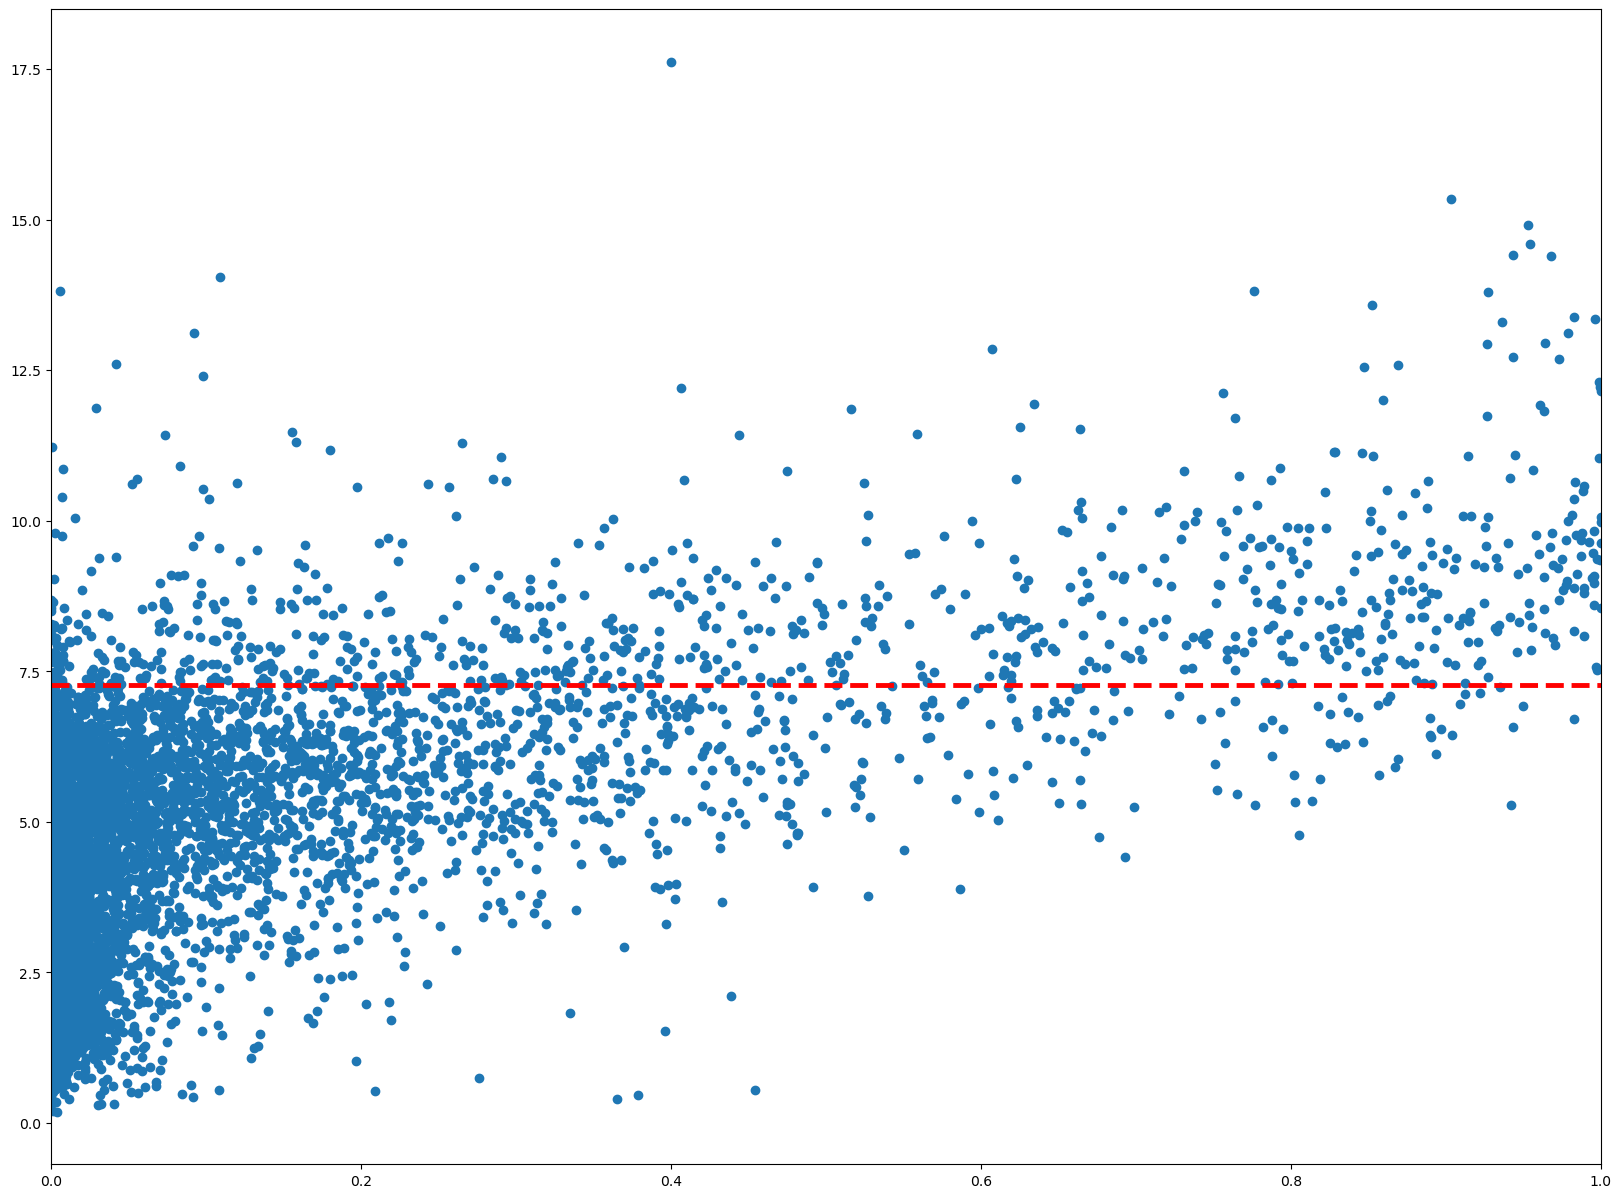

In [207]:
plt.figure(figsize=(20, 15))
plt.scatter(x=testPreds.pred, y=testPreds.effectiveCont)
plt.axhline(7.2734, color='red', linestyle='dashed', linewidth=3.5)
plt.xlim([0,1])
plt.show()

In [208]:
len(set(testPreds[testPreds.pred >= 0.5].drug))

33

In [209]:
len(set(testPreds[(testPreds.pred >= 0.5) & (testPreds.true == 1)].drug))

28

In [212]:
testPreds[testPreds.pred > 0.5].true.sum() / len(testPreds[testPreds.pred > 0.5])

0.7554240631163708

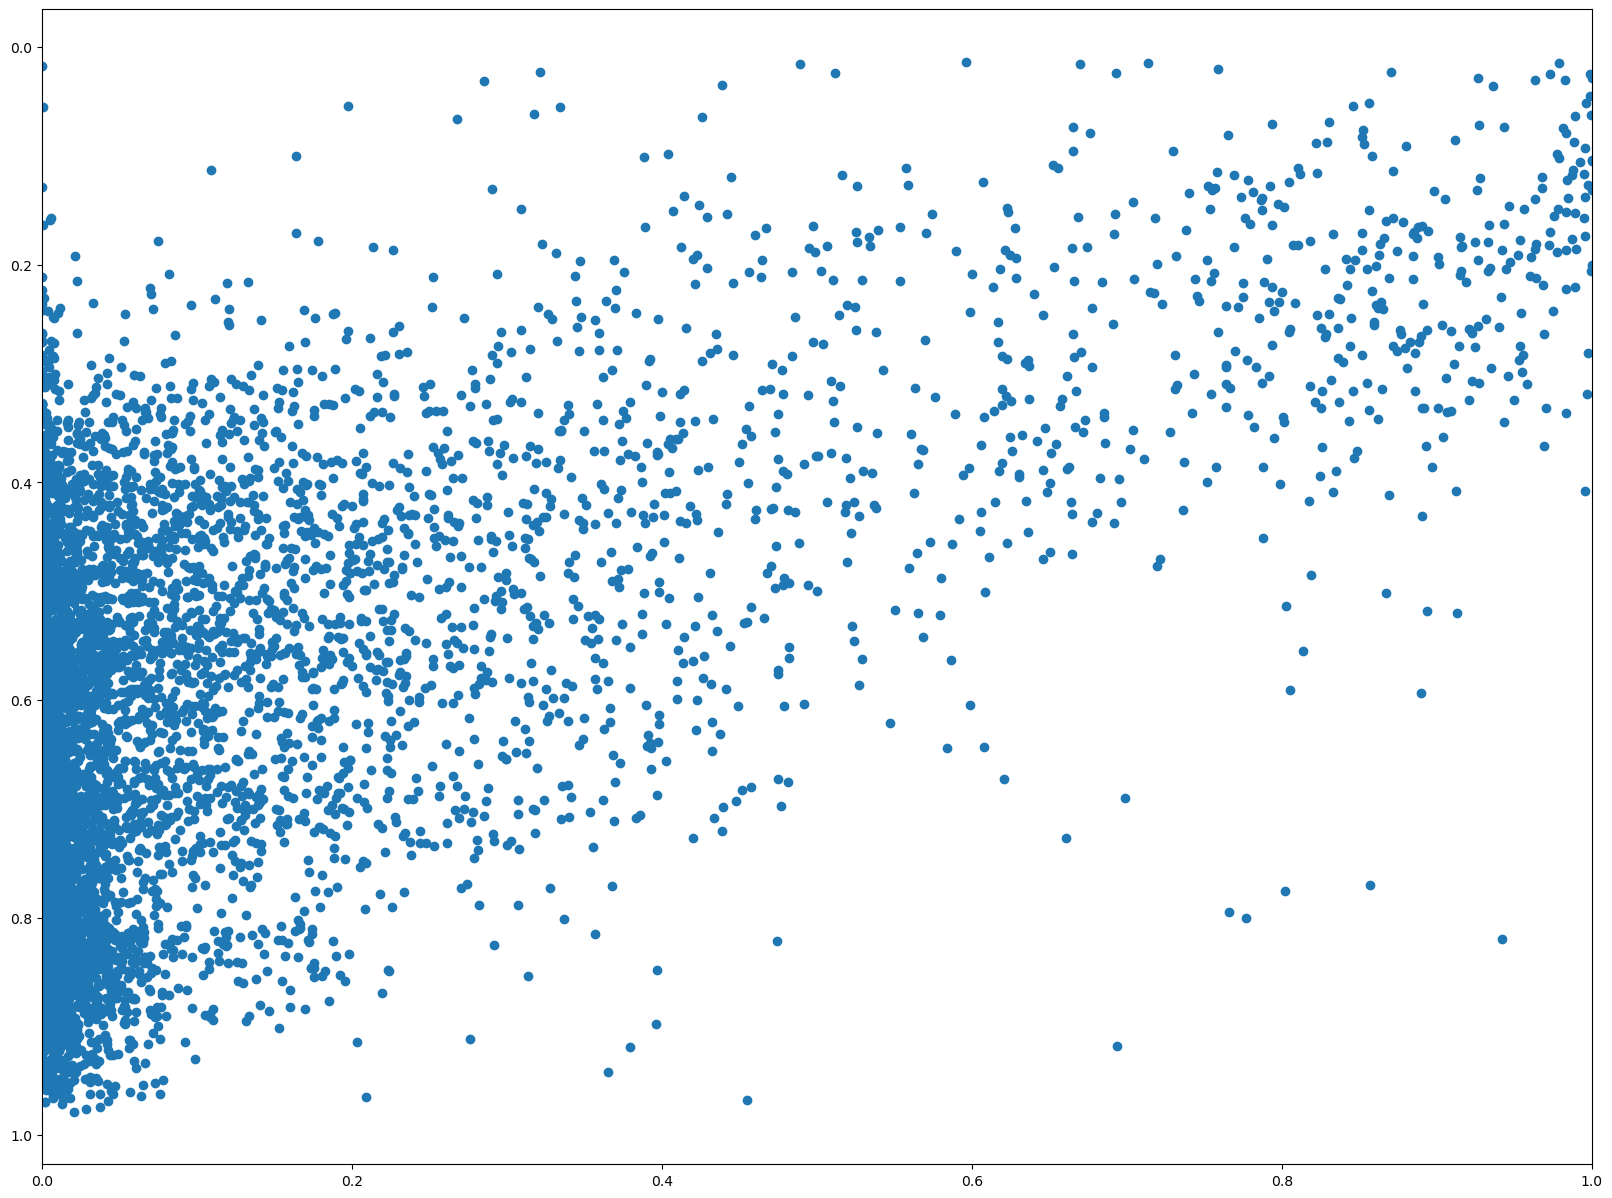

In [213]:
plt.figure(figsize=(20, 15))
plt.scatter(x=testPreds.pred, y=testPreds.auc)
plt.gca().invert_yaxis()
plt.xlim([0,1])
plt.show()

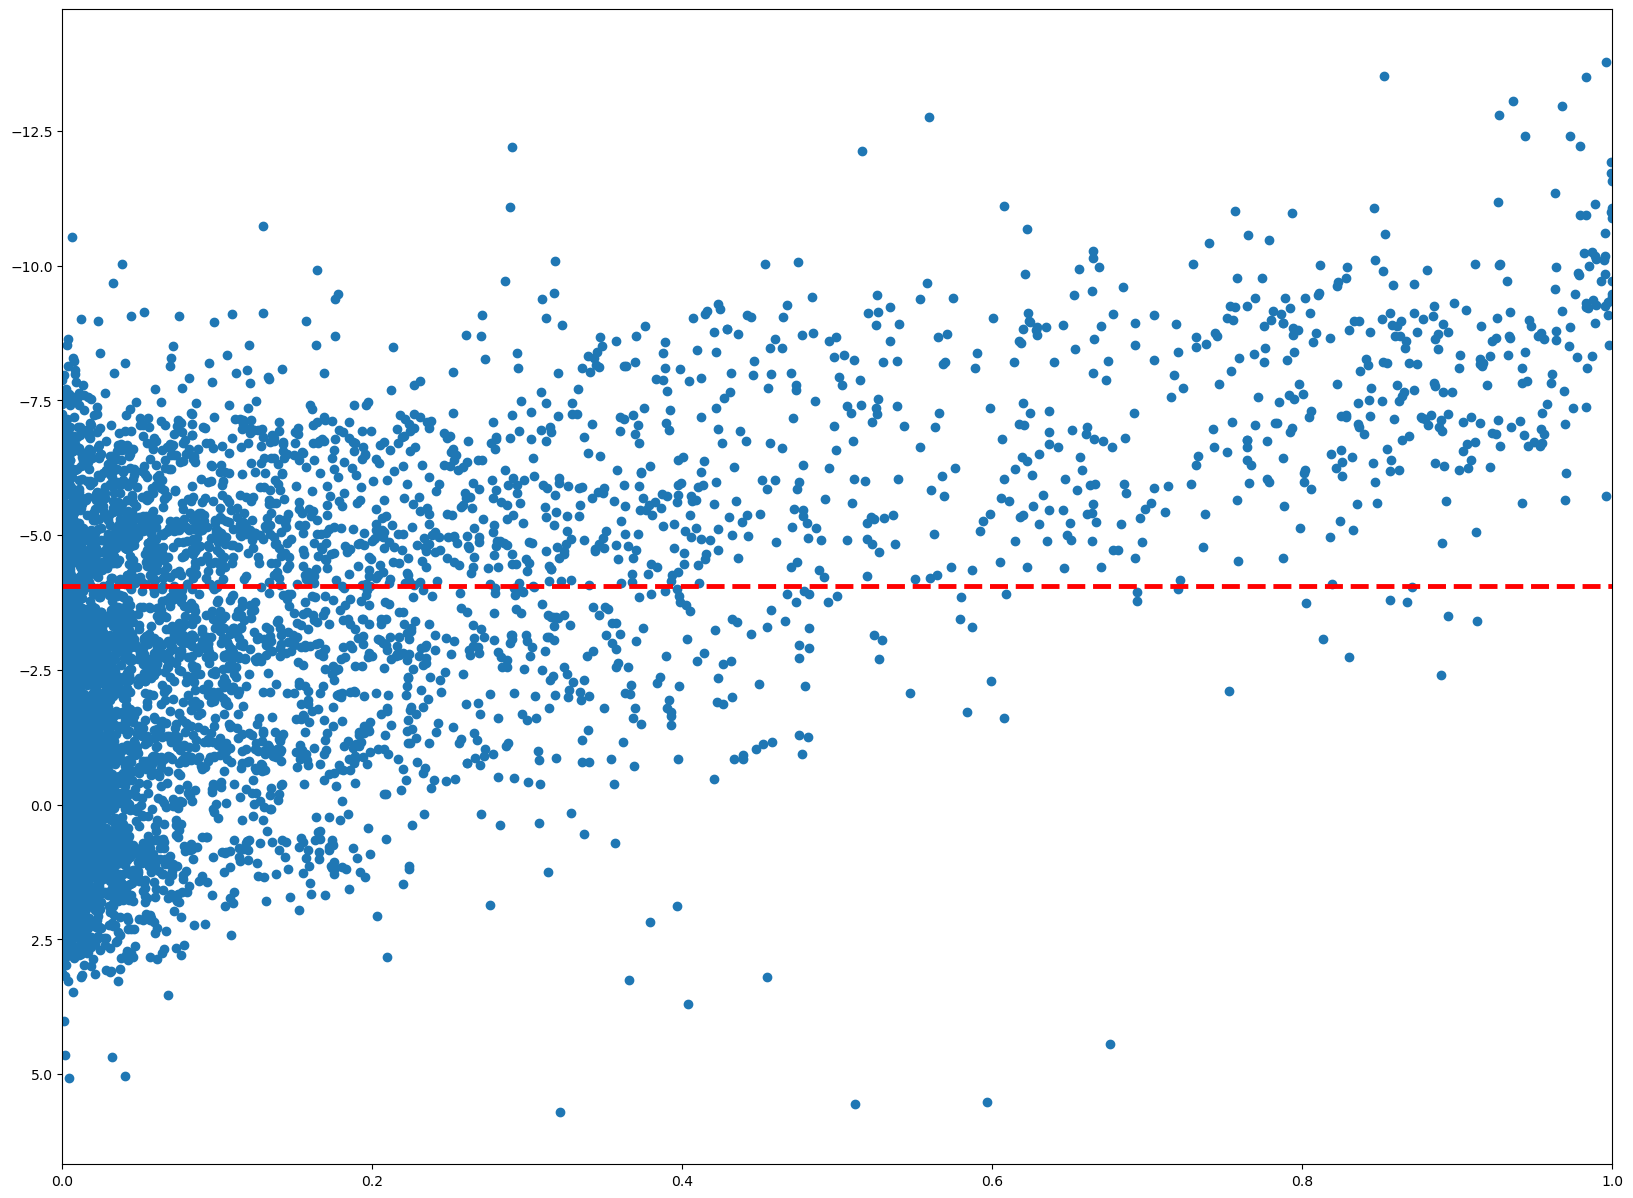

In [214]:
plt.figure(figsize=(20, 15))
plt.scatter(x=testPreds.pred, y=np.log2(testPreds.ic50))
plt.axhline(np.log2(0.06), color='red', linestyle='dashed', linewidth=3.5)
plt.gca().invert_yaxis()
plt.xlim([0,1])
plt.show()

In [215]:
testCount, testWrong = countDrugsK(testPreds, getPcnt=True)
testCount.sort_values(by='total', ascending=False)

,1,2,3,total,pcntCorrect
dolastatin-10,25,7,2,67,0.492537
romidepsin,6,13,3,44,0.500000
10-hydroxycamptothecin,3,9,10,41,0.463415
echinomycin,4,5,9,32,0.437500
triptolide,5,6,1,24,0.500000
genz-644282,1,4,5,19,0.473684
YM-155,0,4,6,18,0.444444
epothilone-b,0,0,8,15,0.466667
maytansinol-isobutyrate,6,0,0,12,0.500000
alvespimycin,1,2,2,9,0.444444


In [216]:
newCount, newWrong = countDrugsK(newPreds, getPcnt=True)
newCount.sort_values(by='total', ascending=False)

No true effective drugs identified in top 3 for ACH-000250 (top drug: dolastatin-10)
No true effective drugs identified in top 3 for ACH-000268 (top drug: sangivamycin)


,1,2,3,total,pcntCorrect
dolastatin-10,27,16,3,91,0.494505
romidepsin,7,14,13,64,0.468750
10-hydroxycamptothecin,3,7,16,50,0.480000
echinomycin,5,7,12,45,0.466667
maytansinol-isobutyrate,13,2,0,30,0.500000
triptolide,8,7,0,30,0.500000
epothilone-b,0,1,8,15,0.400000
genz-644282,1,4,3,13,0.384615
alvespimycin,1,5,2,13,0.384615
YM-155,0,1,5,12,0.500000


In [217]:
len(testCount)

17

In [218]:
testCount.pcntCorrect.mean()

0.4542759831565322

In [219]:
len(set(newCDR[newCDR.pred >= 0.5].drug))

39

In [220]:
len(set(newCDR[(newCDR.pred >= 0.5) & (newCDR.true == 1)].drug))

30

In [221]:
newCDR[newCDR.pred > 0.5].true.sum() / len(newCDR[newCDR.pred > 0.5])

0.7441520467836257